<H1 style="background-color:powderblue;">
    <center>
         Kaggle
     </center>
 </H1>

https://www.kaggle.com/datasets/mariafrenti/age-prediction

<H1 style="background-color:powderblue;">
    <center>
         Imports
     </center>
 </H1>

In [1]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [43]:
from matplotlib                          import pyplot
from matplotlib.image                    import imread
from torchvision.datasets                import ImageFolder
from torch.optim.lr_scheduler            import OneCycleLR
from sklearn.metrics                     import r2_score


import numpy                  as np
import matplotlib.pyplot      as plt
import matplotlib.image       as mpimg
import torchvision.transforms as transforms
import torch.nn               as nn
import torch.nn.functional    as F
import torch.optim            as optim
import torchinfo


import torch
import os
import random
import matplotlib
import torchvision
import torchinfo
import gc 
import os
import time


<H1 style="background-color:powderblue;">
    <center>
         Load Data
     </center>
 </H1>

In [23]:
TRAIN_FOLDER = "/home/amitli/Datasets/Age prediction/20-50/train"
TEST_FOLDER  = "/home/amitli/Datasets/Age prediction/20-50/test"


 #-- ImageNet statistics:
vMean = np.array([0.48501961, 0.45795686, 0.40760392])
vStd  = np.array([0.22899216, 0.224     , 0.225     ])

oTransforms = transforms.Compose([
    #transforms.Resize    (224),
    #transforms.CenterCrop(224),
    transforms.ToTensor  (),
    transforms.Normalize (mean=vMean, std=vStd),
])


batchSize            = 32
oDataSet             = ImageFolder(root=TRAIN_FOLDER, transform=oTransforms)
oTrainSet, oTestSet  = torch.utils.data.random_split(oDataSet, np.round([0.9 * len(oDataSet), 0.1 * len(oDataSet)]).astype(int))

oTrainSet.transform  = oTransforms
oTestSet .transform  = oTransforms

oTrainDL  = torch.utils.data.DataLoader(oTrainSet,   batch_size=batchSize, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,    batch_size=batchSize, num_workers=2, persistent_workers=True)

<H1 style="background-color:powderblue;">
    <center>
         EDA
     </center>
 </H1>

In [29]:
x, y = next(iter(oTrainDL))
print (x[0].shape)

torch.Size([3, 128, 128])


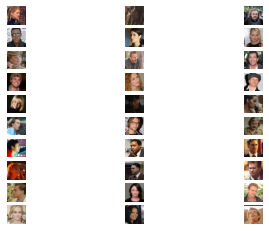

<Figure size 1152x1152 with 0 Axes>

In [72]:
f, axarr = plt.subplots(10,3)

from matplotlib.pyplot import figure
figure(figsize=(16, 16))

for catgory in range(0,3):
    for age in range (20, 30):
       
        image_age = age + 10*catgory       
        img_path  = f"{TRAIN_FOLDER}/{image_age}/"
        img_file  = random.choice(os.listdir(img_path))
        img_fp    = f"{img_path}/{img_file}"
        img       = mpimg.imread(img_fp)       
        axarr[age-20,catgory].imshow(img)
        axarr[age-20,catgory].axis('off')



<H1 style="background-color:powderblue;">
    <center>
         Prepare GPU
     </center>
 </H1>

In [5]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(DEVICE)

cuda:0


<H1 style="background-color:powderblue;">
    <center>
         Transfter Learning (resnet50)
     </center>
 </H1>

In [ ]:
def GetPretrainedModel():
    oModel = torchvision.models.resnet50(pretrained=True)
    #-- freeze weights:
    for mParam in oModel.parameters():
        if False == isinstance(mParam, nn.BatchNorm2d):
            mParam.requires_grad = False
        
    #-- Replace classifier head:
    dIn       = oModel.fc.in_features
    oModel.fc = nn.Sequential(
        nn.Linear(dIn, 512), nn.ReLU(),
        nn.Linear(512, 256), nn.ReLU(),
        nn.Linear(256, 128), nn.ReLU(),
        nn.Linear(128, 31)
    )
    
    return oModel

torchinfo.summary(GetPretrainedModel(), (32, 3, 128, 128))

<H1 style="background-color:powderblue;">
    <center>
         Train and Epoc codes
     </center>
 </H1>

In [ ]:
def Accuracy(mScore, vY):
    vHatY = mScore.detach().argmax(dim=1)
    return (vHatY == vY).float().mean().item()

In [ ]:
def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU


    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)
        vY = vY.to(DEVICE)
                
        #-- Forward:
        if bTrain == True:
            #-- Store computational graph:
            mZ   = oModel(mX)                        
            loss = Loss(mZ, vY)           
        else:
            with torch.no_grad():
                #-- Do not store computational graph:
                mZ   = oModel(mX)                
                loss = Loss(mZ, vY)

        #-- Backward:
        if bTrain == True:
            oOptim.zero_grad() #-- set gradients to zeros
            loss.backward()    #-- backward
            oOptim.step()      #-- update parameters
            if oScheduler is not None:
                vLR[ii] = oScheduler.get_last_lr()[0]
                oScheduler.step() #-- update learning rate

        Nb           = vY.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        epochMetric += Nb * Metric(mZ, vY)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [12]:
#
# AUTO ENCODER
#

def Epoch(oModel, oDataDL, Loss, Metric, oOptim=None, oScheduler=None, bTrain=True):

    epochLoss   = 0
    epochMetric = 0
    count       = 0
    nIter       = len(oDataDL)
    vLR         = np.full(nIter, np.nan)
    DEVICE      = next(oModel.parameters()).device #-- CPU\GPU

    oModel.train(bTrain) #-- train or test

    #-- Iterate over the mini-batches:
    for ii, (mX, _) in enumerate(oDataDL):
        #-- Move to device (CPU\GPU):
        mX = mX.to(DEVICE)

        if bTrain == True:
            #-- Forward:
            mHatX = oModel(mX)
            loss  = Loss  (mHatX, mX)
                    
            #-- Backward:
            vLR[ii] = oScheduler.get_last_lr()[0]
            oOptim    .zero_grad() #-- set gradients to zeros
            loss      .backward () #-- backward
            oOptim    .step     () #-- update parameters
            oScheduler.step     () #-- update learning rate

        else:
            with torch.no_grad():
                #-- Forward:
                mHatX = oModel(mX)
                loss  = Loss  (mHatX, mX)

        Nb           = mX.shape[0]
        count       += Nb
        epochLoss   += Nb * loss.item()
        epochMetric += Nb * Metric(mHatX, mX)
        print(f'\r{"Train" if bTrain else "Val"} - Iteration: {ii:3d} ({nIter}): loss = {loss:2.6f}', end='')

    print('', end='\r')
    epochLoss   /= count
    epochMetric /= count

    return epochLoss, epochMetric, vLR

In [13]:
def TrainModel(oModel, oTrainData, oValData, Loss, Metric, nEpochs, oOptim, oScheduler=None, Epoch=Epoch, sModelName='BestParams'):

    vTrainLoss   = np.full(nEpochs, np.nan)
    vTrainMetric = np.full(nEpochs, np.nan)
    vValLoss     = np.full(nEpochs, np.nan)
    vValMetric   = np.full(nEpochs, np.nan)
    vLR          = np.full(0,       np.nan)
    bestMetric   = -float('inf')

    for epoch in range(nEpochs):
        startTime                    = time.time()
        trainLoss, trainMetric, vLRi = Epoch(oModel, oTrainData, Loss, Metric, oOptim, oScheduler, bTrain=True ) #-- train
        valLoss,   valMetric,   _    = Epoch(oModel, oValData,   Loss, Metric,                     bTrain=False) #-- validate
        epochTime                    = time.time() - startTime

        #-- Display:
        if epoch % 10 == 0:
            print('-' * 120)
        print('Epoch '            f'{epoch       :03d}:',   end='')
        print(' | Train loss: '   f'{trainLoss   :6.3f}',   end='')
        print(' | Val loss: '     f'{valLoss     :6.3f}',   end='')
        print(' | Train Metric: ' f'{trainMetric :6.3f}',   end='')
        print(' | Val Metric: '   f'{valMetric   :6.3f}',   end='')
        print(' | epoch time: '   f'{epochTime   :6.3f} |', end='')

        vTrainLoss  [epoch] = trainLoss
        vTrainMetric[epoch] = trainMetric
        vValLoss    [epoch] = valLoss
        vValMetric  [epoch] = valMetric
        vLR                 = np.concatenate([vLR, vLRi])

        #-- Save best model (early stopping):
        if valMetric > bestMetric:
            bestMetric = valMetric
            try   : torch.save(oModel.state_dict(), sModelName + '.pt')
            except: pass
            print(' <-- Checkpoint!')
        else:
            print('')

    #-- Load best model (early stopping):
    oModel.load_state_dict(torch.load(sModelName + '.pt'))

    return vTrainLoss, vTrainMetric, vValLoss, vValMetric, vLR

<H1 style="background-color:powderblue;">
    <center>
         Train (Transfer learning model)
     </center>
 </H1>

In [ ]:
nEpochs    = 20
nIter      = nEpochs * len(oTrainDL)
Loss       = nn.CrossEntropyLoss()
oModel     = GetPretrainedModel     ().to(DEVICE)
oOptim     = optim.AdamW            (oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=2e-4)
oScheduler = OneCycleLR             (oOptim, max_lr=2e-2, total_steps=nIter)
lHistory   = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler)

<H1 style="background-color:powderblue;">
    <center>
         AutoEncoder
     </center>
 </H1>

In [6]:
def GetEncoder():
    oEncoder = nn.Sequential(
        nn.Identity(),
        nn.Conv2d(3,  8,  kernel_size=3, bias=False), nn.BatchNorm2d(8 ), nn.ReLU(), 
        nn.Conv2d(8,  16, kernel_size=3, bias=False), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(16, 32, kernel_size=3, bias=False), nn.BatchNorm2d(32), nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, bias=False), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(32, 32, kernel_size=3, bias=False), nn.BatchNorm2d(32), nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(64, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(64, 64, kernel_size=3, bias=False), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
        nn.Conv2d(64, 2,  kernel_size=1), 
        nn.Flatten()
    )
    
    return oEncoder
#=============================================================#
#=============================================================#
#torchinfo.summary(GetEncoder(), (32, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [32, 3, 128, 128]         --
├─Conv2d: 1-2                            [32, 8, 126, 126]         216
├─BatchNorm2d: 1-3                       [32, 8, 126, 126]         16
├─ReLU: 1-4                              [32, 8, 126, 126]         --
├─Conv2d: 1-5                            [32, 16, 124, 124]        1,152
├─BatchNorm2d: 1-6                       [32, 16, 124, 124]        32
├─ReLU: 1-7                              [32, 16, 124, 124]        --
├─MaxPool2d: 1-8                         [32, 16, 62, 62]          --
├─Conv2d: 1-9                            [32, 32, 60, 60]          4,608
├─BatchNorm2d: 1-10                      [32, 32, 60, 60]          64
├─ReLU: 1-11                             [32, 32, 60, 60]          --
├─Conv2d: 1-12                           [32, 32, 58, 58]          9,216
├─Bat

In [8]:
def GetDecoder():
    oDecoder = nn.Sequential(
        nn.Identity(),
        nn.Unflatten(1, (2, 1, 1)),
        nn.Upsample(scale_factor=3), nn.Conv2d(2,  8,  kernel_size=2, padding=1, bias=False), nn.BatchNorm2d(8 ), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(8,  16, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(16), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(32), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(32, 40, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(40), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(40, 40, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(40), nn.ReLU(), 
        nn.Upsample(scale_factor=2), nn.Conv2d(40, 40, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(40), nn.ReLU(), 
                                     nn.Conv2d(40, 3,  kernel_size=3, padding=1, bias=False),
        nn.Sigmoid(), 
    )

    return oDecoder

#=============================================================#
#=============================================================#
#torchinfo.summary(GetDecoder(), (32, 2,))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [32, 2]                   --
├─Unflatten: 1-2                         [32, 2, 1, 1]             --
├─Upsample: 1-3                          [32, 2, 3, 3]             --
├─Conv2d: 1-4                            [32, 8, 4, 4]             64
├─BatchNorm2d: 1-5                       [32, 8, 4, 4]             16
├─ReLU: 1-6                              [32, 8, 4, 4]             --
├─Upsample: 1-7                          [32, 8, 8, 8]             --
├─Conv2d: 1-8                            [32, 16, 8, 8]            1,152
├─BatchNorm2d: 1-9                       [32, 16, 8, 8]            32
├─ReLU: 1-10                             [32, 16, 8, 8]            --
├─Upsample: 1-11                         [32, 16, 16, 16]          --
├─Conv2d: 1-12                           [32, 32, 16, 16]          4,608
├─BatchNo

In [9]:
def GetModel():
    oModel = nn.Sequential(
        nn.Identity(),
        GetEncoder (),
        GetDecoder ()
    )
    return oModel
#=============================================================#
#=============================================================#
torchinfo.summary(GetModel(), (32, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [32, 3, 128, 128]         --
├─Sequential: 1-2                        [32, 2]                   --
│    └─Identity: 2-1                     [32, 3, 128, 128]         --
│    └─Conv2d: 2-2                       [32, 8, 126, 126]         216
│    └─BatchNorm2d: 2-3                  [32, 8, 126, 126]         16
│    └─ReLU: 2-4                         [32, 8, 126, 126]         --
│    └─Conv2d: 2-5                       [32, 16, 124, 124]        1,152
│    └─BatchNorm2d: 2-6                  [32, 16, 124, 124]        32
│    └─ReLU: 2-7                         [32, 16, 124, 124]        --
│    └─MaxPool2d: 2-8                    [32, 16, 62, 62]          --
│    └─Conv2d: 2-9                       [32, 32, 60, 60]          4,608
│    └─BatchNorm2d: 2-10                 [32, 32, 60, 60]          64
│    └─R

In [10]:

def R2Score(vHatY, vY):
    vY    = vY   .detach().cpu().view(-1)
    vHatY = vHatY.detach().cpu().view(-1)
    return r2_score(vY, vHatY)

<H1 style="background-color:powderblue;">
    <center>
         Train (AE Model)
     </center>
 </H1>

In [14]:
nEpochs    = 25
nIter      = nEpochs * len(oTrainDL)
Loss       = nn.MSELoss  ()
Metric     = R2Score

oModel     = GetModel     ().to(DEVICE)
oOptim     = optim.AdamW            (oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=2e-4)
oScheduler = OneCycleLR             (oOptim, max_lr=2e-2, total_steps=nIter)


lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, Epoch=Epoch, sModelName='AE')

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  1.389 | Val loss:  1.355 | Train Metric:  0.042 | Val Metric:  0.061 | epoch time: 88.631 | <-- Checkpoint!
Epoch 001: | Train loss:  1.361 | Val loss:  1.352 | Train Metric:  0.061 | Val Metric:  0.063 | epoch time: 88.514 | <-- Checkpoint!
Epoch 002: | Train loss:  1.357 | Val loss:  1.338 | Train Metric:  0.064 | Val Metric:  0.073 | epoch time: 87.039 | <-- Checkpoint!
Epoch 003: | Train loss:  1.352 | Val loss:  1.330 | Train Metric:  0.067 | Val Metric:  0.078 | epoch time: 87.447 | <-- Checkpoint!
Epoch 004: | Train loss:  1.348 | Val loss:  1.332 | Train Metric:  0.070 | Val Metric:  0.077 | epoch time: 86.793 |
Epoch 005: | Train loss:  1.345 | Val loss:  1.358 | Train Metric:  0.072 | Val Metric:  0.059 | epoch time: 86.902 |
Epoch 006: | Train loss:  1.343 | Val loss:  1.331 | Train Metric:  0.074 | Val Metric:  0.078 | epoch time

<H1 style="background-color:powderblue;">
    <center>
         Visualize Encoder Results (Change to 3 categories, instead of 30)
     </center>
 </H1>

In [10]:
# Load model
oModel     = GetModel     ().to(DEVICE)
oModel.load_state_dict(torch.load('AE.pt'))

<All keys matched successfully>

In [16]:
K         = 200
oTrainDL2 = torch.utils.data.DataLoader(oTrainSet, shuffle=True, batch_size=K)
oTestDL2  = torch.utils.data.DataLoader(oTestSet,  shuffle=True, batch_size=K)

mTrainX, vTrainY = next(iter(oTrainDL2))
mTestX,  vTestY  = next(iter(oTestDL2))
oModel.to(DEVICE)

oEncoder = oModel[1]
with torch.no_grad():
    mTrainZ  = oEncoder(mTrainX.to(DEVICE)).cpu().numpy()
    mTestZ   = oEncoder(mTestX.to (DEVICE)).cpu().numpy()

In [89]:
vTmpTrainY = vTrainY.tolist().copy()
vTmpTestY  = vTestY.tolist().copy()

for i in range(len(vTmpTrainY)):
    vTmpTrainY[i] = int((vTmpTrainY[i]) / 10)

for i in range(len(vTmpTestY)):
    vTmpTestY[i] = int((vTmpTestY[i]) / 10)    

In [90]:
max(vTmpTrainY), max(vTmpTestY)

(3, 3)

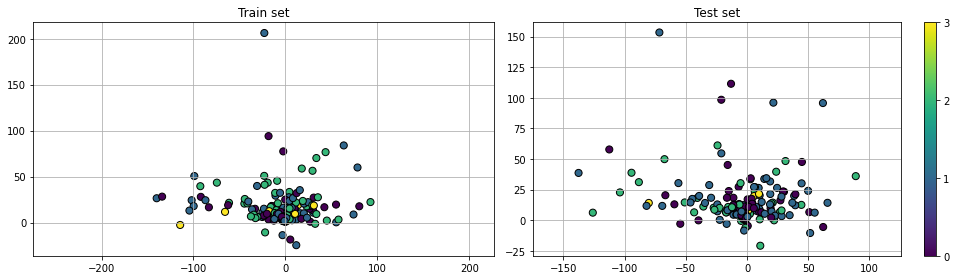

In [92]:
_, ax = plt.subplots(1, 2, figsize=(14, 4))

h1 = ax[0].scatter(mTrainZ[:,0], mTrainZ[:,1], s=50, c=vTmpTrainY, edgecolor='k')
h2 = ax[1].scatter(mTestZ [:,0], mTestZ [:,1], s=50, c=vTmpTestY,  edgecolor='k')
ax[0].set_title   ('Train set')
ax[1].set_title   ('Test set')
ax[0].axis        ('equal')
ax[1].axis        ('equal')
ax[0].grid        ()
ax[1].grid        ()

plt.colorbar    (h2, ticks=range(10))
plt.tight_layout()
plt.show        ()

In [94]:
<H1 style="background-color:powderyellow;">
    <center>
         We can train and test with R2 (MSE) - how much we are close to real age
     </center>
 </H1>

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 4)